## IMPORTING PACKAGES

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import preprocessing
import visualization
import utils
from easydict import EasyDict

## DATA PREPROCESSING

We read all the data, split them into 2 subsets of training and testing data. 

In [3]:
# Training and testing names are given by a variable named 'splits'
from utils import splits

data = {}; data_test = {}
name = ['0zt','8zt','16zt'] # Folders name
for n in name:
    data, data_test = preprocessing.generate_signal_dictionary(data, data_test, scale = False, outlier_filter = False, data_splits = splits, name=n)
    
print(f'There are {len(data)} recordings used for training and {len(data_test)} recordings used for testing')

There are 53 recordings used for training and 15 recordings used for testing


In [4]:
window_size = 1024
hop_length = 1024

In [17]:
df, l = preprocessing.generate_model_data(data_dictionary=data, method = 'spec_img', window_size = window_size, hop_length= hop_length, verbose = True)
df_test, l_test = preprocessing.generate_model_data(data_dictionary=data_test, method = 'spec_img', window_size = window_size, hop_length= hop_length, verbose = True)

Signal processing method: spec_img
Data shape: (169113, 65, 65)
Class distribution (label/n_obs): 1: 10770, 2: 19019, 4: 7466, 5: 93873, 6: 14564, 7: 3606, 8: 19815
Signal processing method: spec_img
Data shape: (49215, 65, 65)
Class distribution (label/n_obs): 1: 2610, 2: 6615, 4: 1599, 5: 24650, 6: 4124, 7: 2838, 8: 6779


In [18]:
from utils import get_two_levels_split

X = get_two_levels_split(df,l)
y = get_two_levels_split(df_test,l_test)

X1 = X.level1; y1 = y.level1
X2 = X.level2; y2 = y.level2

# TRAINING

In [19]:
from models import CNN2D
from train import Trainer

In [20]:
info = EasyDict({'device': 'cuda', 'n_classes': 7, 'num_epochs': 10, 'learning_rate': 0.0001,'batch_size': 128, 'model_type':'cnn', 'seq_length': 513})
model1 = CNN2D()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters())

trainer1 = Trainer(X1,y1,model1,criterion,optimizer,info)
trainer1.get_loader()
trainer1.train()
trainer1.save_checkpoint('CNN2D - 1024-1024 - level1 - 10-01-2024.pth')

Obtaning data loaders...
Train, validate, test lengths: (135290, 33823, 49215)
Input shape: torch.Size([128, 1, 65, 65])
Initialize...
Training...
Epoch [1/10], loss: 0.3534, validation accuracy: 0.9452
Epoch [10/10], loss: 0.0498, validation accuracy: 0.9838
Testing...
Accuracy : 0.9753
Balanced accuracy: 0.9752
Predicted labels: (array([0, 1], dtype=int64), array([23723, 25492], dtype=int64))
True labels: (array([0, 1]), array([24565, 24650], dtype=int64))

Finished!


In [21]:
info = EasyDict({'device': 'cuda', 'n_classes': 7, 'num_epochs': 50, 'learning_rate': 0.0001,'batch_size': 128,'model_type':'cnn', 'seq_length': 513})
model2 = CNN2D()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters())

trainer2 = Trainer(X2,y2,model2,criterion,optimizer,info)
trainer2.get_loader()
trainer2.train()
trainer2.save_checkpoint('CNN2D - 1024-1024 - level2 - 10-01-2024.pth')

Obtaning data loaders...
Train, validate, test lengths: (60192, 15048, 24565)
Input shape: torch.Size([128, 1, 65, 65])
Initialize...
Training...
Epoch [1/50], loss: 0.9383, validation accuracy: 0.8018
Epoch [11/50], loss: 0.2812, validation accuracy: 0.8898
Epoch [21/50], loss: 0.1964, validation accuracy: 0.8943
Epoch [31/50], loss: 0.1395, validation accuracy: 0.8996
Epoch [41/50], loss: 0.1087, validation accuracy: 0.8976
Epoch [50/50], loss: 0.0861, validation accuracy: 0.8951
Testing...
Accuracy : 0.8629
Balanced accuracy: 0.8887
Predicted labels: (array([0, 1, 2, 3, 4, 5], dtype=int64), array([2781, 5968, 1554, 3889, 3007, 7366], dtype=int64))
True labels: (array([0, 1, 2, 3, 4, 5], dtype=int64), array([2610, 6615, 1599, 4124, 2838, 6779], dtype=int64))

Finished!


# PREDICTING

In [28]:
from test import Classifier
from models import CNN2D

models = [CNN2D(), CNN2D()]
path = ['CNN2D - 1024-1024 - level1 - 10-01-2024.pth','CNN2D - 1024-1024 - level2 - 10-01-2024.pth']
device = 'cuda'

test_configs = EasyDict({'method':'spec_img', 'model_type':'cnn','scope':4, 'window_size':1024, 'hop_length':256})
clf = Classifier(models, device)
clf.load_checkpoint(path)
clf.load_configs(test_configs)

Two level classifier
Configurations loaded.


In [29]:
name = ['0zt','8zt','16zt']
acc = []
b_acc = []
for n in name:
    for fn in splits[n][1]:
        print(fn)
        wave_array,ana = data_test[fn]
        clf.predict(wave_array, ana)
        acc.append(clf.acc)
        b_acc.append(clf.b_acc)

0zt_2022-10-19-ch1


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy:  0.957
Balanced accuracy:  0.896
0zt_2022-10-01-ch5
Accuracy:  0.965
Balanced accuracy:  0.8
0zt_2023_2_6-ch1


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy:  0.907
Balanced accuracy:  0.855
0zt_2023_2_5-ch8


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy:  0.99
Balanced accuracy:  0.81
0zt_2023_2_5-ch1


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy:  0.887
Balanced accuracy:  0.754
8zt_2022-10-18-ch5
Accuracy:  0.784
Balanced accuracy:  0.838
8zt_2022_12_28-ch3
Accuracy:  0.89
Balanced accuracy:  0.897
8zt_2022_12_28-ch4
Accuracy:  0.776
Balanced accuracy:  0.772
8zt_2022_01_23-ch2


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy:  0.971
Balanced accuracy:  0.812
8zt_2023_2_07-ch3


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy:  0.917
Balanced accuracy:  0.913
16zt_2023_2_11-ch4


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy:  0.937
Balanced accuracy:  0.885
16zt_2022_10-10-ch4


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy:  0.959
Balanced accuracy:  0.834
16zt_2023_2_10-ch4


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy:  0.973
Balanced accuracy:  0.919
16zt_2023_2_10-ch6


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy:  0.84
Balanced accuracy:  0.805
16zt_2022_10-10-ch2
Accuracy:  0.96
Balanced accuracy:  0.812


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [30]:
avg_acc = round(sum(acc)/len(acc), 3)
avg_b_acc = round(sum(b_acc)/len(b_acc), 3)
print(f'Average accuracy/balanced accuracy over 15 test files are {avg_acc} and {avg_b_acc}, resp.')

Average accuracy/balanced accuracy over 15 test files are 0.914 and 0.84, resp.


# VISUALIZING

C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


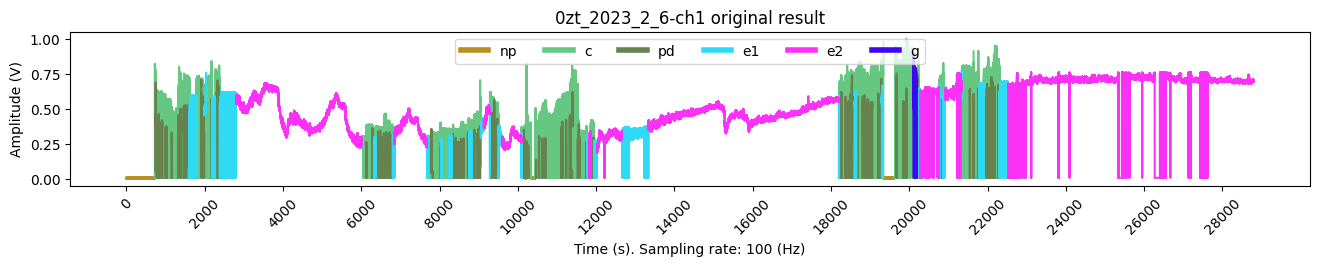

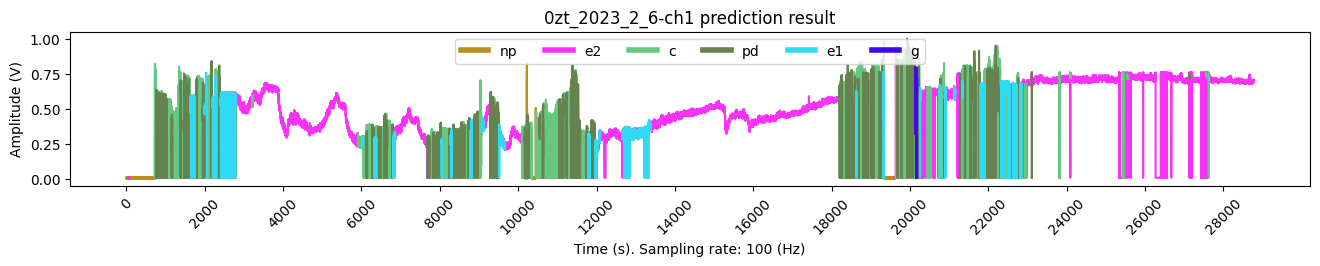

In [35]:
file = splits['0zt'][1][0]
wave_array,ana = data_test[file]

pred_ana = clf.predict(wave_array, ana, verbose = False)
clf.plot()

C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


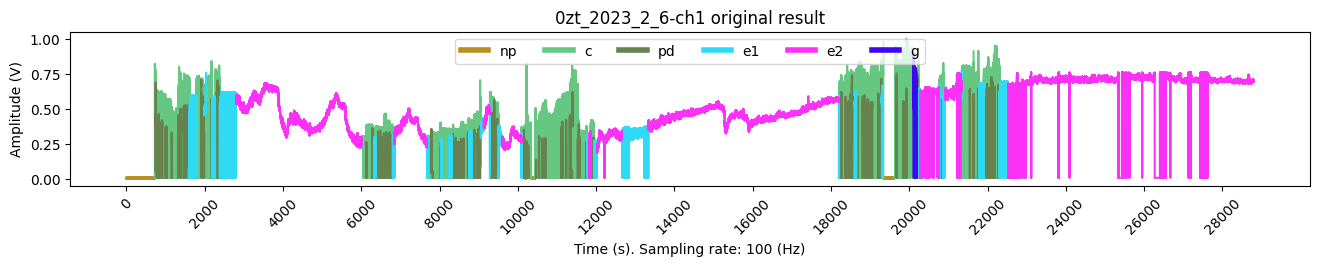

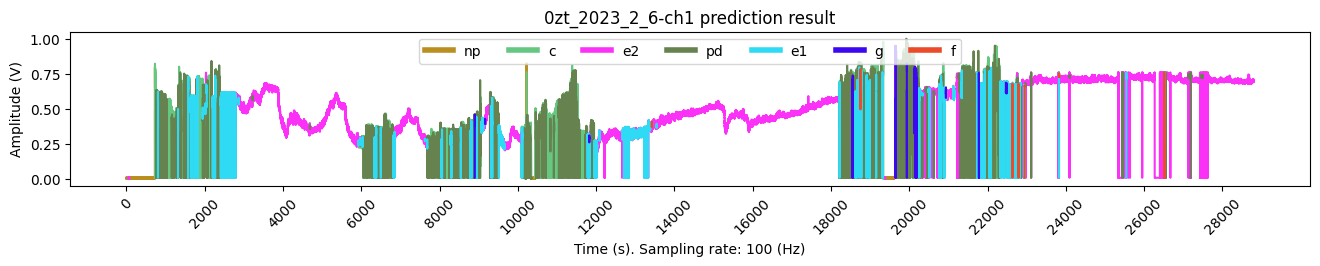

In [20]:
file = splits['0zt'][1][4]
wave_array,ana = data_test[file]

pred_ana = clf.predict(wave_array, ana, verbose = False)
clf.plot()

Accuracy:  0.95
Balanced accuracy:  0.9
[[  50    3    0    0    0    2]
 [   0  412    0    0    5   92]
 [   0    3   75    2    0    3]
 [   0    3    9 8760    0    8]
 [ 358   71    0    4 1375    2]
 [   0    0    0    0    0   10]]


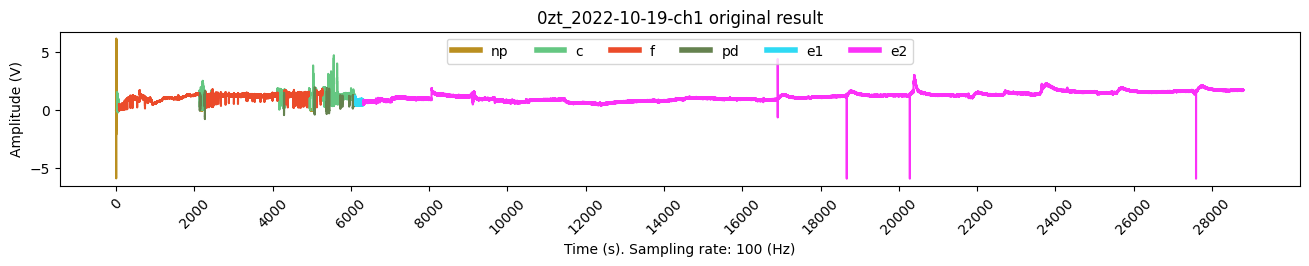

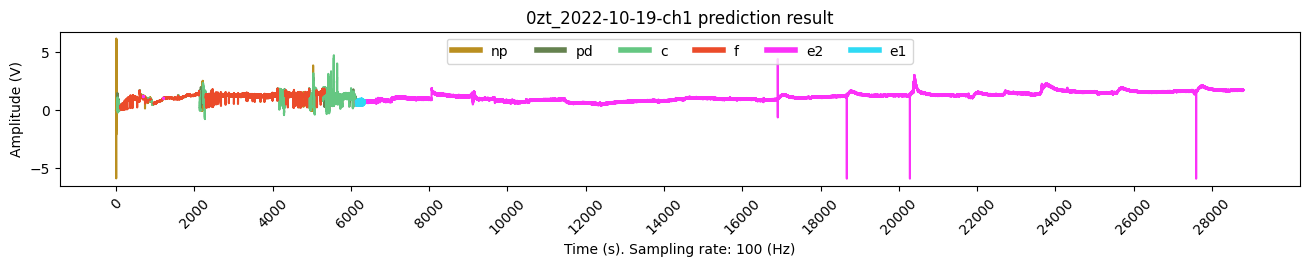

In [15]:
file = splits['8zt'][1][2]
wave_array,ana = data_test[file]

pred_ana = clf.predict(wave_array, ana, verbose = False)
clf.plot()

Accuracy:  0.77
Balanced accuracy:  0.77
[[ 452   11    0    0    0    0    1]
 [   3  971    5    8   22    6  357]
 [   0    5  103   32    0   13    4]
 [   0    4  156 2699    0    1    0]
 [   0    9    0    0   13    0    6]
 [   0   57    2 1923    4 4348    1]
 [   0    1    0    0    0    0   30]]


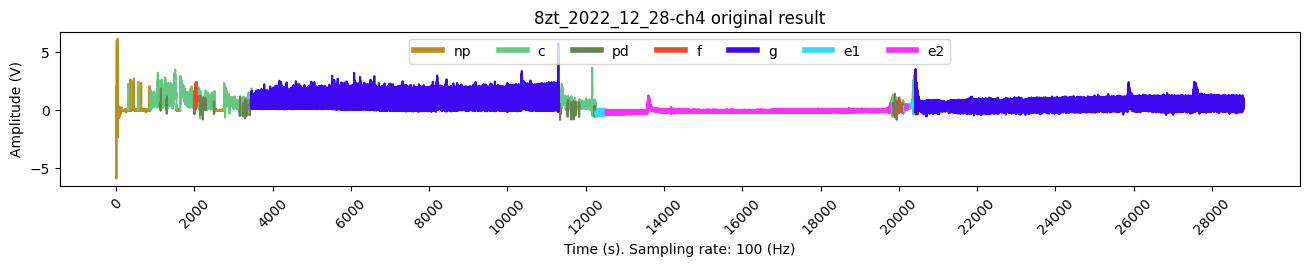

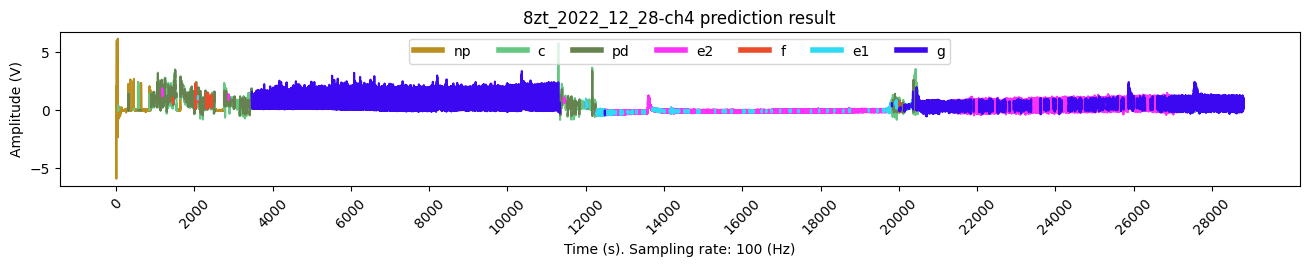

In [16]:
file = splits['16zt'][1][2]
wave_array,ana = data_test[file]

pred_ana = clf.predict(wave_array, ana, verbose = False)
clf.plot()

Accuracy:  0.9
Balanced accuracy:  0.91
[[1277   10    0   10    1    0    9]
 [  84 2343   10    6    4   14  494]
 [   5   11  749   10    0    6   19]
 [ 208   43  115 5031    2    5    3]
 [   0    0    0    0    0    0    0]
 [   0    8    2   50    0  678    0]
 [   2    2    0    0    0    0   36]]


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


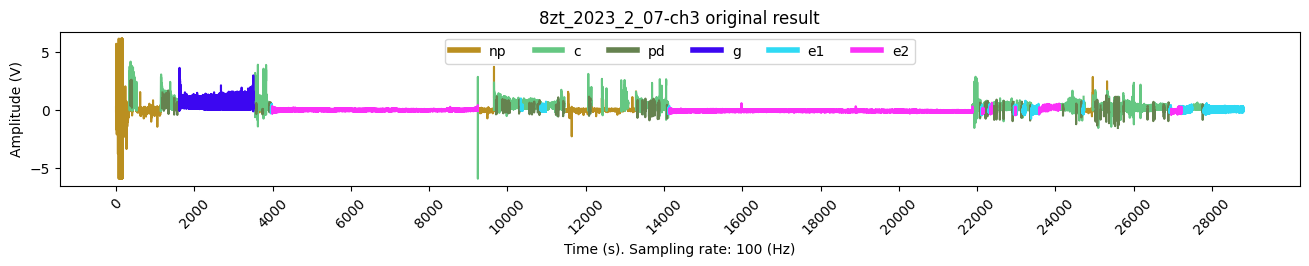

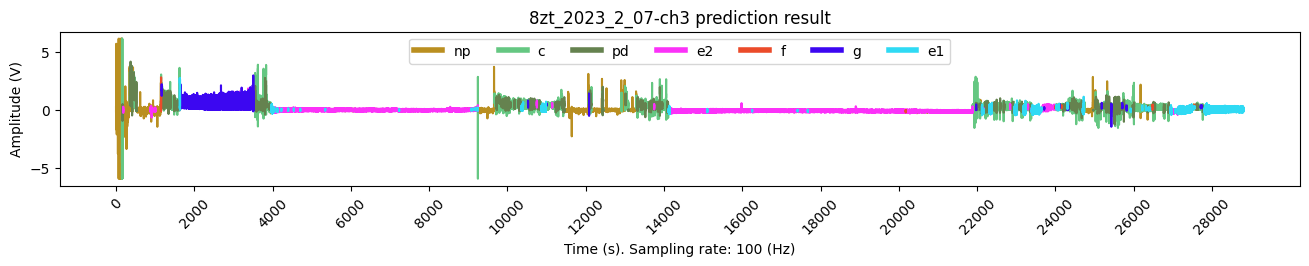

In [17]:
file = splits['8zt'][1][4]
wave_array,ana = data_test[file]

model1.eval()
model2.eval()
pred_ana = two_level_prediction(wave_array,ana,model1,model2,device,mode = 'cnn2d',window_size=1024, hop_length=256)

# pred_ana.to_csv(f'{file}_P.ANA',sep = '\t',header = None,index=None)

pred_ana['time'] = pred_ana['time'].apply(lambda x: x*100).astype(int)

visualization.visualize_wave(wave_array,ana)
plt.title(f'{file} original result')
visualization.visualize_wave(wave_array,pred_ana)
plt.title(f'{file} prediction result')
plt.show()

Accuracy:  0.98
Balanced accuracy:  0.91
[[ 658   16    1    3    6    0    5]
 [   0  618    2    0    0   25   92]
 [   0   45  679   24    0   21    3]
 [   0    0   17 9024    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    1    0    0    0    0    7]]


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


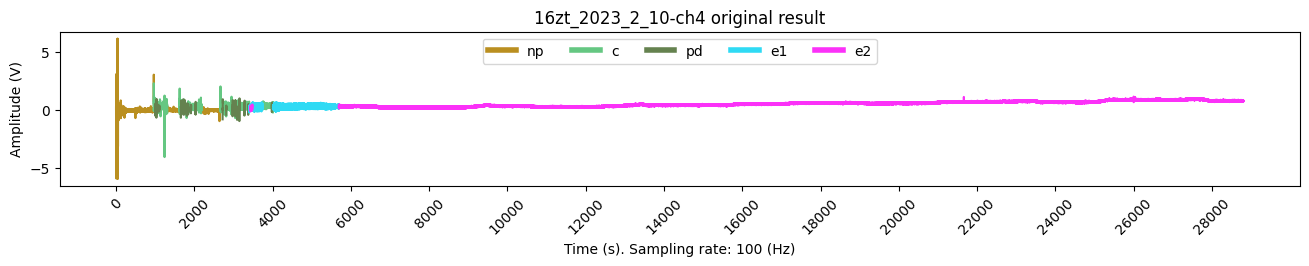

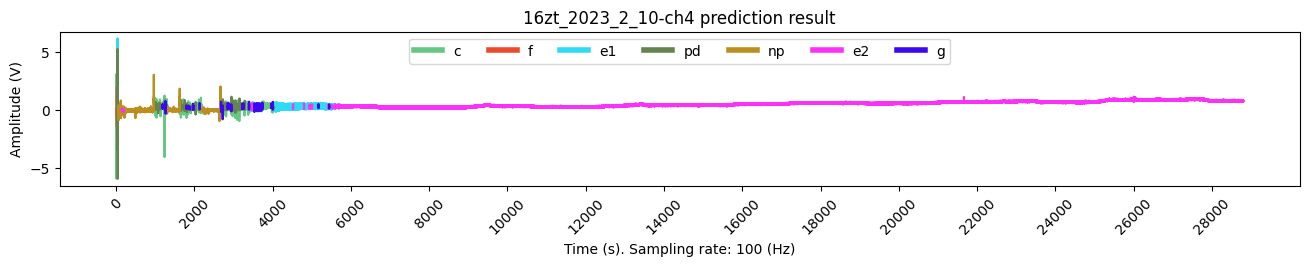

In [20]:
file = splits['16zt'][1][2]
wave_array,ana = data_test[file]

model1.eval()
model2.eval()
pred_ana = two_level_prediction(wave_array,ana,model1,model2,device,mode = 'cnn2d',window_size=1024, hop_length=256)

# pred_ana.to_csv(f'{file}_P.ANA',sep = '\t',header = None,index=None)

pred_ana['time'] = pred_ana['time'].apply(lambda x: x*100).astype(int)

visualization.visualize_wave(wave_array,ana)
plt.title(f'{file} original result')
visualization.visualize_wave(wave_array,pred_ana)
plt.title(f'{file} prediction result')
plt.show()

Accuracy:  0.95
Balanced accuracy:  0.81
[[ 141    9    0    0    0    0    3]
 [   1  990    1    0   13    8  252]
 [   0    8  884   26    0    3    7]
 [   0    0   79 8648    1   45    0]
 [   0   17    0    9   33   44    1]
 [   0    0    0    0    0    0    0]
 [   0    3    0    0    0    0   21]]


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


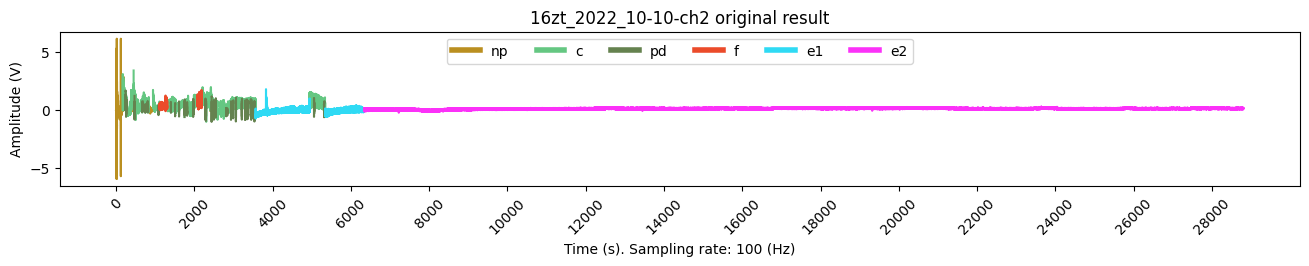

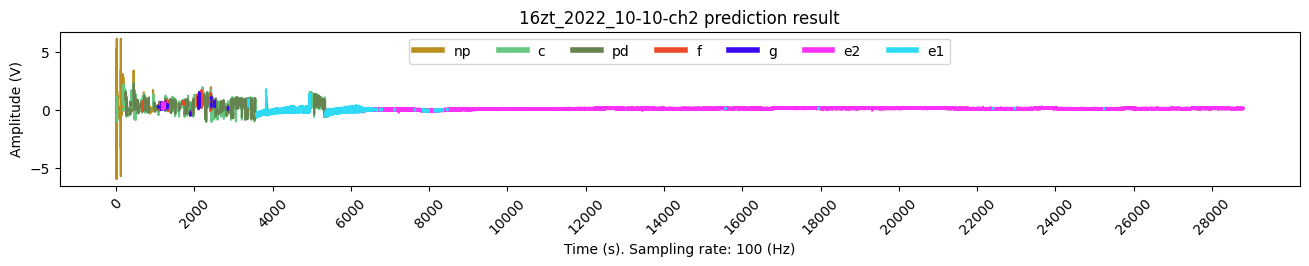

In [21]:
file = splits['16zt'][1][4]
wave_array,ana = data_test[file]

model1.eval()
model2.eval()
pred_ana = two_level_prediction(wave_array,ana,model1,model2,device,mode = 'cnn2d',window_size=1024, hop_length=256)

# pred_ana.to_csv(f'{file}_P.ANA',sep = '\t',header = None,index=None)

pred_ana['time'] = pred_ana['time'].apply(lambda x: x*100).astype(int)

visualization.visualize_wave(wave_array,ana)
plt.title(f'{file} original result')
visualization.visualize_wave(wave_array,pred_ana)
plt.title(f'{file} prediction result')
plt.show()

In [21]:
torch.save(model1,'CNN2D - 1024-1024 - Y-Y - level1 - 08-01-2024.pth')
torch.save(model2,'CNN2D - 1024-1024 - Y-Y - level2 - 08-01-2024.pth')


# Final comment

Our model use direct fft coefficients as input and it has given pretty promising results.

However, there are many further things to improve

- Data augmentation: We could try to oversample the short and minor class such as 'pd' to emphasizes this behavior
- There are noises in the signals that has to be considered, for example: 'np' waves should looks like a flat line but there are instances that 'np' waves amplitudes fluctuate arond 1V
- Our model has not taken into account the relation between waveforms. For example, you can only find 'pd' waves in between pathway 'c' waves, or 'e1' is usually followed up by 'e2', ...